# Summary: Sentiment Analysis Part

### 1. Embeddings for Semantic Search:
#### Embeddings:
- Generated embeddings for plot summaries. These embeddings serve as vector representations, capturing the semantic meaning of the text for further sentiment analysis
- We used mini-LM embedding to allow us to do semantic search to analyse the data better
- We also used Roberta for sentiment and emotions embeddings 

### 2. Sentiment Analysis and Emotion Extraction:

#### Sentiment Analysis Models:
- The model gave us a score between 0 to 1 to be able to know if the plot summary has a more positive or negative tone

#### Emotion Extraction:
- Utilized a sentence transformer model to extract the most frequent emotions from plot summaries that we have breaken down into smaller chunk, for them to fit in the model
- We then extracted the most frequent emotion 
- The different emotion available are: fear, anger, love, suprise, sadness and joy

### 3. Questions Asked:
- Explored correlations between sentiments/emotions from plot summaries and different dependent variables.
- Investigated statistical differences in film subgroups, focusing on war-related topics.

### 4. Statistical Analysis
#### Dependent Variables:

1. Popularity: Explored how emotions and sentiments correlate with the popularity of movies.

2. Average Rating: Investigated the impact of emotions and sentiments on the average rating of movies.

3. Box Office Revenue: Assessed the relationship between emotions, sentiments, and box office revenue.

4. Decade: Explored temporal patterns or changes over decades.

#### Tests Conducted:
##### Chi-square Tests:
- Applied to assess the association between emotions, sentiments, and dependent variables.
- Variables: Emotions and Sentiments
- Purpose: To examine the association between emotions and sentiments.

##### Mann-Whitney U Tests:
- Used to compare box office revenue between different sentiment categories and emotion types within subgroups.
- Variables: Subgroups based on semantic search for films about ['Cold War', 'Vietnam', 'World War 2', "Nazi", "Iraq", "Afghanistan"].
- Purpose: Investigate treatment differences.


In [1]:
pip install sentence_transformers scikit-multilearn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd 
import plotly.graph_objs as go
import json
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency



In [3]:
CREATE_EMBEDDINGS = False
SENTIMENT_EMBEDDING = False

In [4]:
if CREATE_EMBEDDINGS:
    df_cmu = pd.read_csv("dataQ1/imdb/merged_file_imdb.csv")
    tqdm.pandas()

    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    df = pd.read_csv('dataset/cmu_merged_with_imdb.csv')
    df['embeddings'] = df['PlotSummaries'].progress_apply(lambda x: model.encode(x))

    df['embeddings'] = df['embeddings'].apply(lambda x: ','.join(map(str, x)))
    df.to_csv('embeddings.csv', index=False)
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
    queries = ['query 1', 'query 2', 'query 3']
    query_embeddings = model.encode(queries)

    embeddings = np.stack(df_cmu['embeddings'].values)
    similarity_results = []
    for query_emb in query_embeddings:
        similarities = cosine_similarity([query_emb], embeddings)
        similarity_results.append(similarities[0])

In [5]:
df_cmu = pd.read_csv("data/movies_metadata.csv")
df_cmu.columns

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/4260520398.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cmu = pd.read_csv("data/movies_metadata.csv")


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [6]:

if SENTIMENT_EMBEDDING:
    df_cmu = pd.read_csv("dataset/cmu_merged_with_imdb.csv")

    def split_text_into_chunks(text, chunk_size=512):
        return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

    chunks_data = {
        'film_id': [],
        'text_chunk': []
    }
    for index, row in df_cmu.iterrows():
        film_id = row['IMDbID'] 
        plot_summary = row['PlotSummaries']
        
        chunks = split_text_into_chunks(plot_summary, 512)
        
        for chunk in chunks:
            chunks_data['film_id'].append(film_id)
            chunks_data['text_chunk'].append(chunk)

    df_chunks = pd.DataFrame(chunks_data)
    
    model = pipeline('sentiment-analysis', model="finiteautomata/bertweet-base-sentiment-analysis")
    tqdm.pandas()
    df_chunks['sentiment'] = df_chunks['text_chunk'][:10].progress_apply(model)
    df_chunks.to_csv('sentiment2.csv', index=False)
    df_chunks = pd.read_csv("dataset/sentiment2.csv")
    df_chunks[["film_id", "emotion", "sentiment_scores"]].head(10)
    


In [7]:
if SENTIMENT_EMBEDDING:
    def extract_emotion_label(row):
        emotion_data = eval(row['sentiment'])
        return emotion_data[0]['label'] if emotion_data else None

    df_chunks['emotion_label'] = df_chunks.apply(extract_emotion_label, axis=1)

    emotion_counts = df_chunks.groupby(['film_id', 'emotion_label']).size().reset_index(name='counts')

    def most_frequent_emotion(group):
        return group.sort_values('counts', ascending=False).iloc[0]['emotion_label']

    most_frequent_sentiments = emotion_counts.groupby('film_id').apply(most_frequent_emotion).reset_index(name='most_frequent_emotion')
    most_frequent_sentiments

In [8]:
if SENTIMENT_EMBEDDING:
    def determine_overall_sentiment(sentiment_list):
        for sentiment in sentiment_list:
            if sentiment[0]['label'] == 'NEGATIVE':
                return 'NEGATIVE'
        return 'POSITIVE'


    df_chunks['sentiment_scores'] = df_chunks['sentiment_scores'].apply(eval)
    grouped = df_chunks.groupby('film_id')['sentiment_scores'].agg(list)

    grouped = df_chunks.groupby('film_id')['sentiment_scores'].agg(list)
    df_final_sentiment = grouped.apply(determine_overall_sentiment).reset_index(name='overall_sentiment')
    df_final_sentiment

In [9]:
if SENTIMENT_EMBEDDING:
    merged_df = pd.merge(df_cmu, df_final_sentiment, left_on='IMDbID', right_on='film_id', how='inner')
    merged_df = pd.merge(merged_df, most_frequent_sentiments, left_on='IMDbID', right_on='film_id', how='inner')
    merged_df = merged_df.drop(['film_id_y', 'film_id_x'], axis=1)

    merged_df.to_csv('dataset/cmu_merged_with_imdb.csv', index=False)
    merged_df

In [10]:
merged_df = pd.read_csv('dataset/cmu_merged_with_imdb.csv')
merged_df

,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres,Category,overall_sentiment_x,most_frequent_emotion_x,overall_sentiment_y,most_frequent_emotion_y,overall_sentiment,most_frequent_emotion
0,tt0228333,Ghosts of Mars,2001,14010832.0,98.0,English,United States of America,"Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi",Non Socio-Political,NEGATIVE,fear,NEGATIVE,fear,NEGATIVE,fear
1,tt0097499,Henry V,1989,10161099.0,137.0,English,United Kingdom,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History",Non Socio-Political,POSITIVE,love,POSITIVE,love,POSITIVE,love
2,tt0058331,Mary Poppins,1964,102272727.0,139.0,English,United States of America,The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy",Socio-Political,NEGATIVE,anger,NEGATIVE,anger,NEGATIVE,anger
3,tt0255819,Baby Boy,2001,29381649.0,123.0,English,United States of America,A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance",Socio-Political,NEGATIVE,anger,NEGATIVE,anger,NEGATIVE,anger
4,tt0367546,Bindiya Chamkegi,1984,NaN,NaN,Hindi,India,Shalini 'Shalu' lives a wealthy lifestyle with...,4.9,"Comedy,Family",Non Socio-Political,NEGATIVE,anger,NEGATIVE,anger,NEGATIVE,anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14945,tt0107057,Guilty as Sin,1993,22886222.0,107.0,None,United States of America,Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller",Socio-Political,NEGATIVE,anger,NEGATIVE,anger,NEGATIVE,anger
14946,tt0372937,Into the Mirror,2003,NaN,113.0,Korean,South Korea,After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror",Non Socio-Political,NEGATIVE,fear,NEGATIVE,fear,NEGATIVE,fear
14947,tt0109922,Gopi Kishan,1994,NaN,NaN,Hindi,India,Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama",Socio-Political,NEGATIVE,anger,NEGATIVE,anger,NEGATIVE,anger
14948,tt0033660,The Ghost Train,1941,NaN,82.0,English,United Kingdom,{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror",Socio-Political,NEGATIVE,fear,NEGATIVE,fear,NEGATIVE,fear


In [11]:
merged_df = merged_df.merge(df_cmu, left_on='IMDbID', right_on='imdb_id', how='inner')

In [12]:
merged_df

,IMDbID,MovieName,MovieReleaseDate,MovieBoxOfficeRevenue,MovieRuntime,MovieLanguages,MovieCountries,PlotSummaries,averageRating,genres_x,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,tt0228333,Ghosts of Mars,2001,14010832.0,98.0,English,United States of America,"Set in the second half of the 22nd century, th...",4.9,"Action,Horror,Sci-Fi",...,2001-08-24,14010832.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror is the same on any planet.,Ghosts of Mars,False,4.8,299.0
1,tt0097499,Henry V,1989,10161099.0,137.0,English,United Kingdom,{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,7.5,"Biography,Drama,History",...,1989-10-05,0.0,137.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The great adventure of a king who defied the o...,Henry V,False,7.4,73.0
2,tt0058331,Mary Poppins,1964,102272727.0,139.0,English,United States of America,The film opens with Mary Poppins perched in a...,7.8,"Comedy,Family,Fantasy",...,1964-08-27,102272727.0,139.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It's supercalifragilisticexpialidocious!,Mary Poppins,False,7.4,1217.0
3,tt0255819,Baby Boy,2001,29381649.0,123.0,English,United States of America,A young 20-year-old named Jody lives with his...,6.4,"Crime,Drama,Romance",...,2001-06-27,29381649.0,130.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just a Baby Boy.,Baby Boy,False,7.3,57.0
4,tt0097790,Loverboy,1989,3960327.0,98.0,English,United States of America,"Randy Bodek is a rebellious college slacker, ...",6.0,Comedy,...,1989-04-28,3960327.0,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Randy Bodek has no idea how to treat a woman ....,Loverboy,False,5.5,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,tt0107057,Guilty as Sin,1993,22886222.0,107.0,None,United States of America,Jennifer Haines is an up-and-coming Chicago a...,5.7,"Crime,Drama,Thriller",...,1993-06-04,22886222.0,107.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"She's finally met her match. He's handsome, we...",Guilty as Sin,False,5.6,21.0
10121,tt0372937,Into the Mirror,2003,NaN,113.0,Korean,South Korea,After accidentally causing the death of his pa...,6.4,"Action,Fantasy,Horror",...,2003-08-14,0.0,113.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Into the Mirror,False,6.1,23.0
10122,tt0109922,Gopi Kishan,1994,NaN,NaN,Hindi,India,Kishan killed a man in his childhood when the...,5.8,"Action,Comedy,Drama",...,1994-01-01,0.0,0.0,[],Released,NaN,Gopi Kishan,False,5.0,1.0
10123,tt0033660,The Ghost Train,1941,NaN,82.0,English,United Kingdom,{{plot}} The film opens with a Great Western e...,6.2,"Comedy,Horror",...,1941-01-01,0.0,85.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Ghost Train,False,6.0,9.0


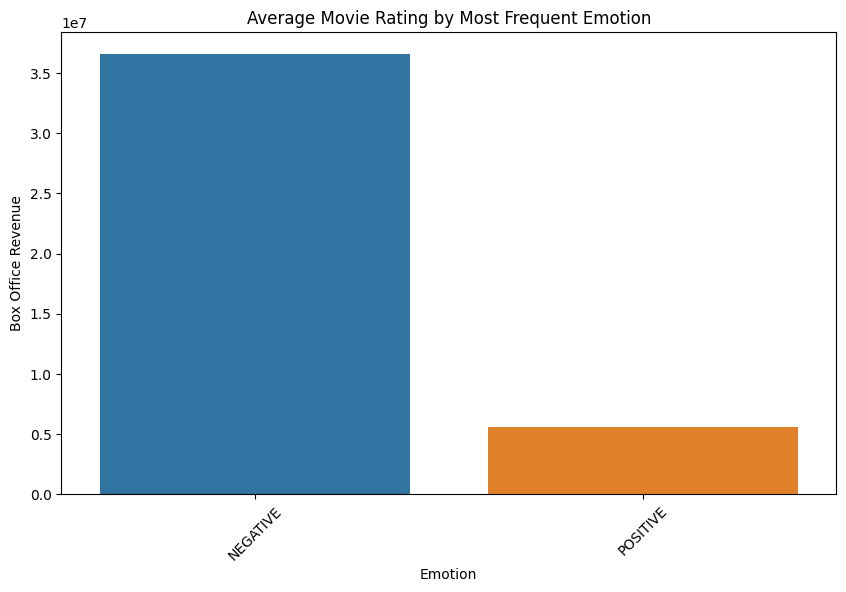

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.799270e-25
POSITIVE,3.799270e-25,0.000000e+00


In [13]:

# Calculate average rating by sentiment and sentiment
avg_rating_by_sentiment = merged_df.groupby('overall_sentiment_y')['revenue'].mean().reset_index()

# Perform t-tests and store results
sentiment_ttest_results = {}
for sentiment1 in avg_rating_by_sentiment['overall_sentiment_y']:
    for sentiment2 in avg_rating_by_sentiment['overall_sentiment_y']:
        if sentiment1 != sentiment2:
            group1 = merged_df[merged_df['overall_sentiment_y'] == sentiment1]['revenue']
            group2 = merged_df[merged_df['overall_sentiment_y'] == sentiment2]['revenue']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            sentiment_ttest_results[(sentiment1, sentiment2)] = p_val


plt.figure(figsize=(10, 6))
sns.barplot(x='overall_sentiment_y', y='revenue', data=avg_rating_by_sentiment)
plt.title('Average Movie Rating by Most Frequent Emotion')
plt.xlabel('Emotion')
plt.ylabel('Box Office Revenue')
plt.xticks(rotation=45)

plt.show()

sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
    p_values_matrix.at[sentiment1, sentiment2] = p_val

# Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
for i in range(len(sentiments)):
    for j in range(i+1, len(sentiments)):
        sentiment1, sentiment2 = sentiments[i], sentiments[j]
        p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

p_values_matrix


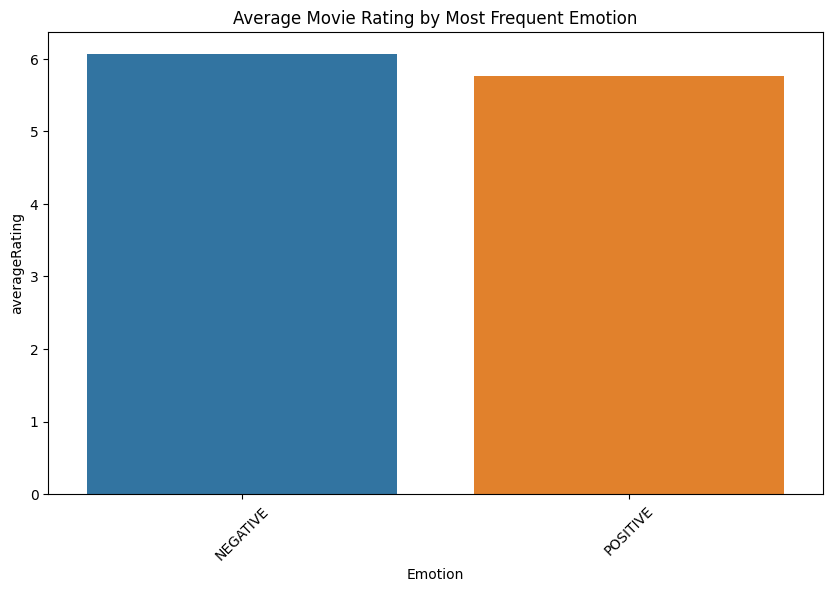

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.667565e-16
POSITIVE,3.667565e-16,0.000000e+00


In [14]:

# Calculate average rating by sentiment and sentiment
avg_rating_by_sentiment = merged_df.groupby('overall_sentiment_y')['vote_average'].mean().reset_index()

# Perform t-tests and store results
sentiment_ttest_results = {}
for sentiment1 in avg_rating_by_sentiment['overall_sentiment_y']:
    for sentiment2 in avg_rating_by_sentiment['overall_sentiment_y']:
        if sentiment1 != sentiment2:
            group1 = merged_df[merged_df['overall_sentiment_y'] == sentiment1]['vote_average']
            group2 = merged_df[merged_df['overall_sentiment_y'] == sentiment2]['vote_average']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            sentiment_ttest_results[(sentiment1, sentiment2)] = p_val


plt.figure(figsize=(10, 6))
sns.barplot(x='overall_sentiment_y', y='vote_average', data=avg_rating_by_sentiment)
plt.title('Average Movie Rating by Most Frequent Emotion')
plt.xlabel('Emotion')
plt.ylabel('averageRating')
plt.xticks(rotation=45)

plt.show()

sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
    p_values_matrix.at[sentiment1, sentiment2] = p_val

# Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
for i in range(len(sentiments)):
    for j in range(i+1, len(sentiments)):
        sentiment1, sentiment2 = sentiments[i], sentiments[j]
        p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

p_values_matrix


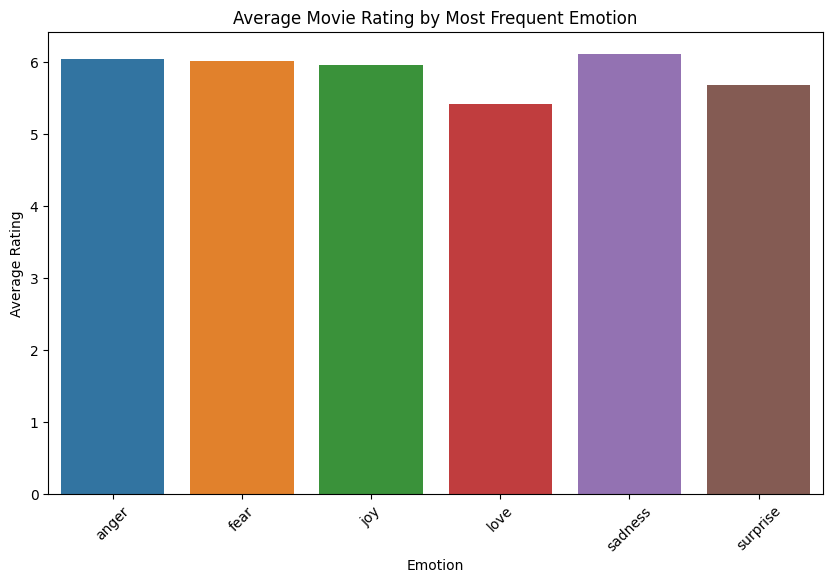

,anger,fear,joy,love,sadness,surprise
anger,0.000000,0.167088,0.045524,0.000047,0.348900,0.308887
fear,0.167088,0.000000,0.306843,0.000063,0.121809,0.331547
joy,0.045524,0.306843,0.000000,0.003884,0.085916,0.506838
love,0.000047,0.000063,0.003884,0.000000,0.000472,0.648422
sadness,0.348900,0.121809,0.085916,0.000472,0.000000,0.290432
surprise,0.308887,0.331547,0.506838,0.648422,0.290432,0.000000


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Assuming 'merged_df' is your merged DataFrame containing necessary columns

# Calculate average rating by emotion and sentiment
avg_rating_by_emotion = merged_df.groupby('most_frequent_emotion_x')['vote_average'].mean().reset_index()

# Perform t-tests and store results
# This is a simplified example; you might want to customize these comparisons
emotion_ttest_results = {}
for emotion1 in avg_rating_by_emotion['most_frequent_emotion_x']:
    for emotion2 in avg_rating_by_emotion['most_frequent_emotion_x']:
        if emotion1 != emotion2:
            group1 = merged_df[merged_df['most_frequent_emotion_x'] == emotion1]['vote_average']
            group2 = merged_df[merged_df['most_frequent_emotion_x'] == emotion2]['vote_average']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            emotion_ttest_results[(emotion1, emotion2)] = p_val



# Plotting and annotating for emotions
plt.figure(figsize=(10, 6))
sns.barplot(x='most_frequent_emotion_x', y='vote_average', data=avg_rating_by_emotion)
plt.title('Average Movie Rating by Most Frequent Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

plt.show()

emotions = sorted(set([pair[0] for pair in emotion_ttest_results.keys()]))

# Initialize a DataFrame with zeros
p_values_matrix = pd.DataFrame(0, index=emotions, columns=emotions)

# Populate the DataFrame with the p-values
for (emotion1, emotion2), p_val in emotion_ttest_results.items():
    p_values_matrix.at[emotion1, emotion2] = p_val

# Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
for i in range(len(emotions)):
    for j in range(i+1, len(emotions)):
        emotion1, emotion2 = emotions[i], emotions[j]
        p_values_matrix.at[emotion2, emotion1] = p_values_matrix.at[emotion1, emotion2]

p_values_matrix

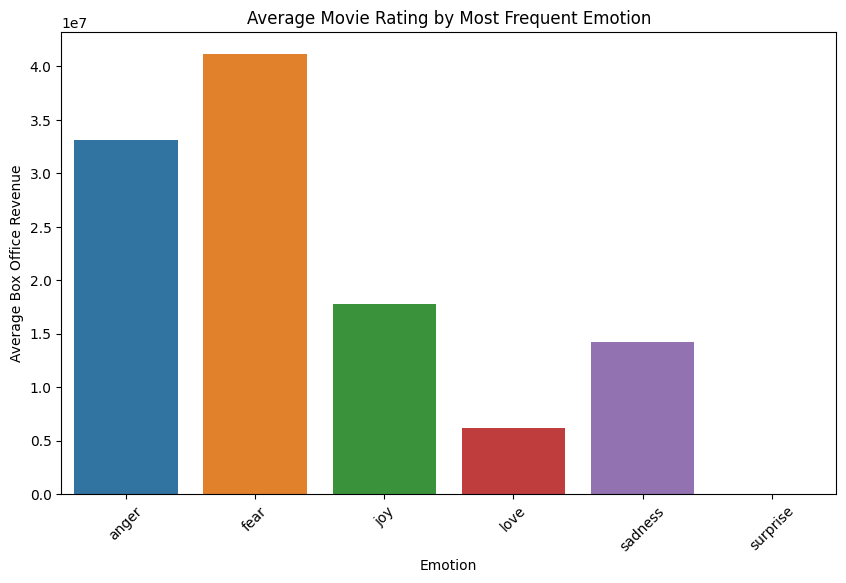

,anger,fear,joy,love,sadness,surprise
anger,0.000000,9.821658e-04,4.005613e-06,0.033857,0.000454,0.265454
fear,0.000982,0.000000e+00,1.103099e-10,0.009183,0.000003,0.190495
joy,0.000004,1.103099e-10,0.000000e+00,0.130188,0.321723,0.319480
love,0.033857,9.182896e-03,1.301879e-01,0.000000,0.195537,0.395277
sadness,0.000454,2.676883e-06,3.217234e-01,0.195537,0.000000,0.318671
surprise,0.265454,1.904946e-01,3.194796e-01,0.395277,0.318671,0.000000


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Assuming 'merged_df' is your merged DataFrame containing necessary columns

# Calculate average rating by emotion and sentiment
avg_rating_by_emotion = merged_df.groupby('most_frequent_emotion')['revenue'].mean().reset_index()

# Perform t-tests and store results
emotion_ttest_results = {}
for emotion1 in avg_rating_by_emotion['most_frequent_emotion']:
    for emotion2 in avg_rating_by_emotion['most_frequent_emotion']:
        if emotion1 != emotion2:
            group1 = merged_df[merged_df['most_frequent_emotion'] == emotion1]['revenue']
            group2 = merged_df[merged_df['most_frequent_emotion'] == emotion2]['revenue']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            emotion_ttest_results[(emotion1, emotion2)] = p_val



# Plotting and annotating for emotions
plt.figure(figsize=(10, 6))
sns.barplot(x='most_frequent_emotion', y='revenue', data=avg_rating_by_emotion)
plt.title('Average Movie Rating by Most Frequent Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Box Office Revenue')
plt.xticks(rotation=45)

plt.show()

emotions = sorted(set([pair[0] for pair in emotion_ttest_results.keys()]))

p_values_matrix = pd.DataFrame(0, index=emotions, columns=emotions)

# Populate the DataFrame with the p-values
for (emotion1, emotion2), p_val in emotion_ttest_results.items():
    p_values_matrix.at[emotion1, emotion2] = p_val

# Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
for i in range(len(emotions)):
    for j in range(i+1, len(emotions)):
        emotion1, emotion2 = emotions[i], emotions[j]
        p_values_matrix.at[emotion2, emotion1] = p_values_matrix.at[emotion1, emotion2]

p_values_matrix

In [17]:
merged_df['popularity']= merged_df['popularity'].apply(float)

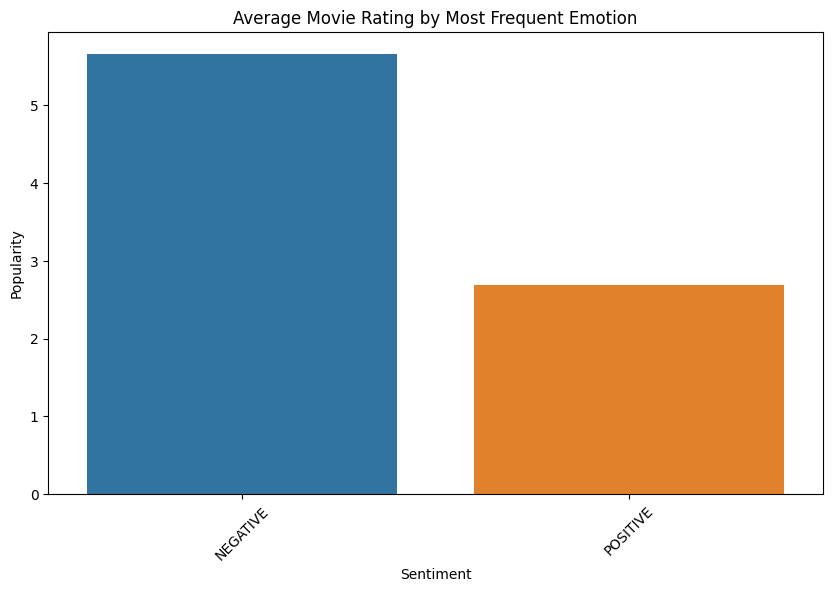

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.703456e-73
POSITIVE,2.703456e-73,0.000000e+00


In [18]:

# Calculate average rating by sentiment and sentiment
avg_rating_by_sentiment = merged_df.groupby('overall_sentiment_y')['popularity'].mean().reset_index()

# Perform t-tests and store results
sentiment_ttest_results = {}
for sentiment1 in avg_rating_by_sentiment['overall_sentiment_y']:
    for sentiment2 in avg_rating_by_sentiment['overall_sentiment_y']:
        if sentiment1 != sentiment2:
            group1 = merged_df[merged_df['overall_sentiment_y'] == sentiment1]['popularity']
            group2 = merged_df[merged_df['overall_sentiment_y'] == sentiment2]['popularity']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            sentiment_ttest_results[(sentiment1, sentiment2)] = p_val


plt.figure(figsize=(10, 6))
sns.barplot(x='overall_sentiment_y', y='popularity', data=avg_rating_by_sentiment)
plt.title('Average Movie Rating by Most Frequent Emotion')
plt.xlabel('Sentiment')
plt.ylabel('Popularity')
plt.xticks(rotation=45)

plt.show()


sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
    p_values_matrix.at[sentiment1, sentiment2] = p_val

# Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
for i in range(len(sentiments)):
    for j in range(i+1, len(sentiments)):
        sentiment1, sentiment2 = sentiments[i], sentiments[j]
        p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

display(p_values_matrix)


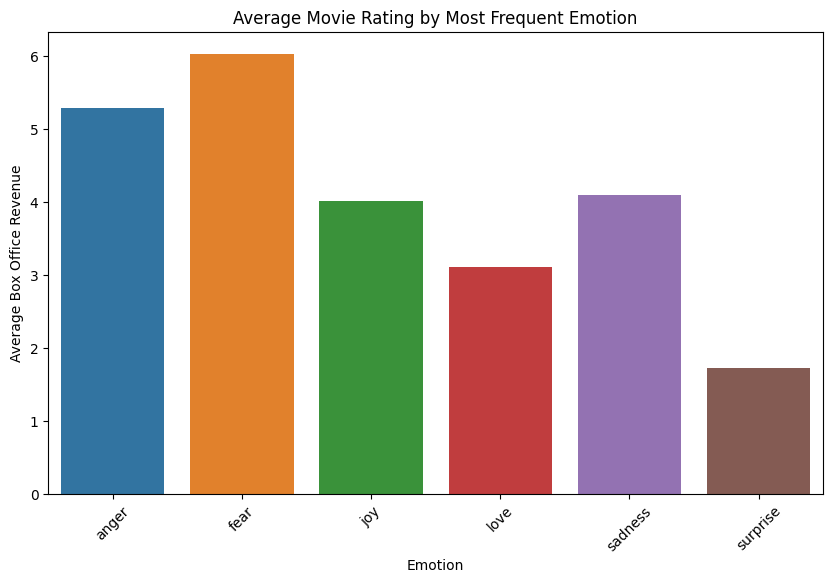

,anger,fear,joy,love,sadness,surprise
anger,0.000000e+00,1.941236e-08,1.058043e-11,0.002151,8.526493e-05,0.031567
fear,1.941236e-08,0.000000e+00,3.773752e-26,0.000017,5.765706e-11,0.006442
joy,1.058043e-11,3.773752e-26,0.000000e+00,0.089544,7.138489e-01,0.058833
love,2.151000e-03,1.712959e-05,8.954398e-02,0.000000,5.869313e-02,0.220717
sadness,8.526493e-05,5.765706e-11,7.138489e-01,0.058693,0.000000e+00,0.037521
surprise,3.156728e-02,6.441628e-03,5.883329e-02,0.220717,3.752112e-02,0.000000


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Assuming 'merged_df' is your merged DataFrame containing necessary columns

# Calculate average rating by emotion and sentiment
avg_rating_by_emotion = merged_df.groupby('most_frequent_emotion')['popularity'].mean().reset_index()

# Perform t-tests and store results
emotion_ttest_results = {}
for emotion1 in avg_rating_by_emotion['most_frequent_emotion']:
    for emotion2 in avg_rating_by_emotion['most_frequent_emotion']:
        if emotion1 != emotion2:
            group1 = merged_df[merged_df['most_frequent_emotion'] == emotion1]['popularity']
            group2 = merged_df[merged_df['most_frequent_emotion'] == emotion2]['popularity']
            t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
            emotion_ttest_results[(emotion1, emotion2)] = p_val



# Plotting and annotating for emotions
plt.figure(figsize=(10, 6))
sns.barplot(x='most_frequent_emotion', y='popularity', data=avg_rating_by_emotion)
plt.title('Average Movie Rating by Most Frequent Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Box Office Revenue')
plt.xticks(rotation=45)

plt.show()

emotions = sorted(set([pair[0] for pair in emotion_ttest_results.keys()]))

p_values_matrix = pd.DataFrame(0, index=emotions, columns=emotions)

# Populate the DataFrame with the p-values
for (emotion1, emotion2), p_val in emotion_ttest_results.items():
    p_values_matrix.at[emotion1, emotion2] = p_val

# Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
for i in range(len(emotions)):
    for j in range(i+1, len(emotions)):
        emotion1, emotion2 = emotions[i], emotions[j]
        p_values_matrix.at[emotion2, emotion1] = p_values_matrix.at[emotion1, emotion2]

p_values_matrix

In [20]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

emotion_colors = {
    'anger': '#E63946',  # Red
    'fear': '#F4A261',   # Sandy Brown
    'sadness': '#A8DADC', # Powder Blue
    'love': '#9C89B8',   # Muted Purple
    'surprise': '#F0C808',# Mustard
    'joy': '#2A9D8F'     # Teal
}

sentiment_colors = {
    'POSITIVE': '#264653', # Charcoal
    'NEGATIVE': '#6D6875'  # Muted Lavender
}


avg_rating_by_emotion = merged_df.groupby('most_frequent_emotion_x')['vote_average'].mean().reset_index()

avg_rating_by_sentiment = merged_df.groupby('overall_sentiment_x')['vote_average'].mean().reset_index()

avg_boxoffice_by_sentiment = merged_df.groupby('overall_sentiment_x')['revenue'].mean().reset_index()

avg_boxoffice_by_emotion = merged_df.groupby('most_frequent_emotion_x')['revenue'].mean().reset_index()

avg_popularity_by_sentiment = merged_df.groupby('overall_sentiment_x')['popularity'].mean().reset_index()

avg_popularity_by_emotion = merged_df.groupby('most_frequent_emotion_x')['popularity'].mean().reset_index()


import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


fig = make_subplots(rows=3, cols=2, subplot_titles=('Average Movie Rating by Most Frequent Emotion',
                                                     'Average Movie Rating by Overall Sentiment',
                                                     'Box Office by Overall Sentiment',
                                                     'Box Office by Most Frequent Emotion',
                                                     'Popularity by Overall Sentiment',
                                                     'Popularity by Most Frequent Emotion'))

fig.add_trace(go.Bar(x=avg_rating_by_emotion['most_frequent_emotion_x'], 
                     y=avg_rating_by_emotion['vote_average'],
                     marker_color=[emotion_colors[emo] for emo in avg_rating_by_emotion['most_frequent_emotion_x']]), 
              row=1, col=1)

fig.add_trace(go.Bar(x=avg_rating_by_sentiment['overall_sentiment_x'], 
                     y=avg_rating_by_sentiment['vote_average'],
                     marker_color=[sentiment_colors[sent] for sent in avg_rating_by_sentiment['overall_sentiment_x']]), 
              row=1, col=2)

fig.add_trace(go.Bar(x=avg_boxoffice_by_sentiment['overall_sentiment_x'], 
                     y=avg_boxoffice_by_sentiment['revenue'],
                     marker_color=[sentiment_colors[sent] for sent in avg_boxoffice_by_sentiment['overall_sentiment_x']]), 
              row=2, col=2)

fig.add_trace(go.Bar(x=avg_boxoffice_by_emotion['most_frequent_emotion_x'], 
                     y=avg_boxoffice_by_emotion['revenue'],
                     marker_color=[emotion_colors[emo] for emo in avg_boxoffice_by_emotion['most_frequent_emotion_x']]), 
              row=2, col=1)

fig.add_trace(go.Bar(x=avg_popularity_by_sentiment['overall_sentiment_x'], 
                     y=avg_popularity_by_sentiment['popularity'],
                     marker_color=[sentiment_colors[sent] for sent in avg_boxoffice_by_sentiment['overall_sentiment_x']]), 
              row=3, col=2)

fig.add_trace(go.Bar(x=avg_popularity_by_emotion['most_frequent_emotion_x'], 
                     y=avg_popularity_by_emotion['popularity'],
                     marker_color=[emotion_colors[emo] for emo in avg_boxoffice_by_emotion['most_frequent_emotion_x']]), 
              row=3, col=1)

fig.update_layout(height=800, width=1000, title_text="Analysis by Emotion and Sentiment")
fig.show()


fig_json = fig.to_json()

with open('figures/boxoffice-ratings.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [21]:
merged_df["genres"] = merged_df.genres_y.apply(eval)

def extract_genres(list_):
    genres  = str()
    for index, item in enumerate(list_):
        if index != len(list_)-1:
            res = item['name']+","
            genres += res
        else:
            res = item['name'] 
            genres += res
    return genres

merged_df["genres"] = merged_df["genres"].apply(extract_genres)

In [22]:
merged_df[["genres",'most_frequent_emotion_x' ]]

,genres,most_frequent_emotion_x
0,"Action,Horror,Science Fiction",fear
1,"War,Drama,History,Action,Romance",love
2,"Comedy,Family,Fantasy",anger
3,"Crime,Drama,Romance",anger
4,"Comedy,Romance",anger
...,...,...
10120,"Drama,Thriller",anger
10121,"Crime,Horror,Mystery",fear
10122,,anger
10123,"Comedy,Horror,Mystery,Thriller",fear


In [53]:
import plotly.graph_objects as go
import pandas as pd
genres_of_interest = ['Action', 'Adventure', "Drama", "Crime", "Comedy", "Romance", "Thriller", "War", "Fantasy", "History", "Science Fiction", "Documentary"]

all_genres = []
for index, row in merged_df.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        if genre in genres_of_interest:
            all_genres.append({'Genre': genre, 'Emotion': row['most_frequent_emotion_x']})

flattened_df = pd.DataFrame(all_genres)

sentiment_count = flattened_df.groupby(['Genre', 'Emotion']).size().unstack().fillna(0)

fig = go.Figure(data=[
    go.Bar(name='anger', x=sentiment_count.index, y=sentiment_count['anger']),
    go.Bar(name='fear', x=sentiment_count.index, y=sentiment_count['fear']),
    go.Bar(name='sadness', x=sentiment_count.index, y=sentiment_count['sadness']),
    go.Bar(name='love', x=sentiment_count.index, y=sentiment_count['love']),
    go.Bar(name='surprise', x=sentiment_count.index, y=sentiment_count['surprise']),
    go.Bar(name='joy', x=sentiment_count.index, y=sentiment_count['joy'])
])

fig.update_layout(barmode='group', title='Sentiment Analysis by Individual Movie Genres')

fig.show()
fig_json = fig.to_json()

with open('figures/emotion_genres_hist.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [54]:
import plotly.graph_objects as go
import pandas as pd

all_genres = []
genres_of_interest = ['Action', 'Adventure', "Drama", "Crime", "Comedy", "Romance", "Thriller", "War", "Fantasy", "History", "Science Fiction", "Documentary"]

for index, row in merged_df.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        if genre in genres_of_interest:
            all_genres.append({'Genre': genre, 'Sentiment': row['overall_sentiment_x']})

flattened_df = pd.DataFrame(all_genres)

sentiment_count = flattened_df.groupby(['Genre', 'Sentiment']).size().unstack().fillna(0)

fig = go.Figure(data=[
    go.Bar(name='POSITIVE', x=sentiment_count.index, y=sentiment_count['POSITIVE']),
    go.Bar(name='NEGATIVE', x=sentiment_count.index, y=sentiment_count['NEGATIVE']),
])

fig.update_layout(barmode='group', title='Sentiment Analysis by Individual Movie Genres')

fig.show()
fig_json = fig.to_json()

with open('figures/sentiment_genres_hist.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [55]:

all_genres = []
for index, row in merged_df.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        if genre in genres_of_interest: 
            all_genres.append({'Genre': genre, 'Emotion': row['overall_sentiment_x']})

flattened_df = pd.DataFrame(all_genres)

sentiment_count = flattened_df.groupby(['Genre', 'Emotion']).size().unstack().fillna(0)

proportions = sentiment_count.div(sentiment_count.sum(axis=1), axis=0)

fig = go.Figure(data=[
    go.Bar(name='Positive', x=proportions.index, y=proportions['POSITIVE']),
    go.Bar(name='Negative', x=proportions.index, y=proportions['NEGATIVE'])
])

fig.update_layout(barmode='stack', title='Sentiment Analysis by Individual Movie Genres')

fig.show()


fig_json = fig.to_json()

with open('figures/genre-sentiment.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [56]:

rows = []
for _, row in merged_df.iterrows():
    movie_genres = row['genres'].split(',')
    for genre in genres_of_interest:
        if genre in movie_genres:
            rows.append({'genre': genre, 'overall_sentiment': row['overall_sentiment']})


genre_sentiments = pd.DataFrame(rows)

genre_sentiment_counts = genre_sentiments.groupby(['genre', 'overall_sentiment']).size().unstack(fill_value=0)
genre_sentiment_counts['total'] = genre_sentiment_counts.sum(axis=1)
genre_sentiment_counts['expected_positive'] = genre_sentiment_counts['total'] * 0.5
genre_sentiment_counts['expected_negative'] = genre_sentiment_counts['total'] * 0.5

# Prepare the observed and expected frequencies for the Chi-Square test
observed_interest = genre_sentiment_counts[['POSITIVE', 'NEGATIVE']].values.flatten()
expected_interest = genre_sentiment_counts[['expected_positive', 'expected_negative']].values.flatten()

# Conduct the Chi-Square Goodness of Fit Test for the genres of interest
chi2_stat_interest, p_value_interest, dof_interest, _ = chi2_contingency([observed_interest, expected_interest])

print(f"Chi-squared: {chi2_stat_interest}, p-value: {p_value_interest}, degree of freedom: {dof_interest}")
display(genre_sentiment_counts)

Chi-squared: 7307.265846486346, p-value: 0.0, degree of freedom: 23


overall_sentiment,NEGATIVE,POSITIVE,total,expected_positive,expected_negative
genre,,,,,
Action,1882,162,2044,1022.0,1022.0
Adventure,1079,106,1185,592.5,592.5
Comedy,3116,454,3570,1785.0,1785.0
Crime,1332,130,1462,731.0,731.0
Documentary,78,51,129,64.5,64.5
Drama,4609,756,5365,2682.5,2682.5
Fantasy,641,50,691,345.5,345.5
History,273,46,319,159.5,159.5
Romance,1893,345,2238,1119.0,1119.0


We suppose uniform distribution

Given the high Chi-Square statistic and the low p-value, we reject the null hypothesis, which means there is a statistically significant difference in sentiment distribution across the different genres. In other words, the proportion of 'NEGATIVE' to 'POSITIVE' sentiments is not uniform across the genres.

This result can have various implications depending on the context. For instance, it might suggest that certain genres are more likely to evoke negative sentiments among viewers or critics, or it may reflect biases in the production of films within certain genres. Further investigation would be needed to understand the underlying causes of this distribution.

In [57]:
import plotly.graph_objects as go
import pandas as pd


all_genres = []
for index, row in merged_df.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        if genre in genres_of_interest:
            all_genres.append({'Genre': genre, 'Emotion': row['most_frequent_emotion_x']})

flattened_df = pd.DataFrame(all_genres)

sentiment_count = flattened_df.groupby(['Genre', 'Emotion']).size().unstack().fillna(0)

proportions = sentiment_count.div(sentiment_count.sum(axis=1), axis=0)

# Creating the figure with stacked bars for proportions
fig = go.Figure(data=[
    go.Bar(name='anger', x=proportions.index, y=proportions['anger']),
    go.Bar(name='fear', x=proportions.index, y=proportions['fear']),
    go.Bar(name='sadness', x=proportions.index, y=proportions['sadness']),
    go.Bar(name='love', x=proportions.index, y=proportions['love']),
    go.Bar(name='surprise', x=proportions.index, y=proportions['surprise']),
    go.Bar(name='joy', x=proportions.index, y=proportions['joy'])
])

fig.update_layout(barmode='stack', title='Proportional Sentiment Analysis by Movie Genre')

fig.show()

fig_json = fig.to_json()

with open('figures/genre-emotion.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [28]:


rows = []
for _, row in merged_df.iterrows():
    movie_genres = row['genres'].split(',')
    for genre in genres_of_interest:
        if genre in movie_genres:
            rows.append({'genre': genre, 'most_frequent_emotion': row['most_frequent_emotion']})


genre_emotion = pd.DataFrame(rows)
emotion_counts = genre_emotion.groupby(['genre', 'most_frequent_emotion']).size().unstack(fill_value=0)

emotion_counts['total'] = emotion_counts.sum(axis=1)

expected_uniform = emotion_counts['total'].values / emotion_counts.shape[1]

expected_emotions = pd.DataFrame([expected_uniform] * emotion_counts.shape[1]).T
expected_emotions.columns = emotion_counts.columns
expected_emotions.index = emotion_counts.index

# Perform the Chi-Square Goodness of Fit Test
chi2_stat, p_value, dof, expected = chi2_contingency(emotion_counts)

emotion_counts_with_expected = emotion_counts.copy()
for i, column in enumerate(emotion_counts.columns):
    emotion_counts_with_expected['expected_' + column] = expected[:, i]


chi2_stat, p_value, dof, expected = chi2_contingency(emotion_counts)


# Display the results
print(f"Chi-squared: {chi2_stat}, p-value: {p_value}, degree of freedom: {dof}")
display(emotion_counts_with_expected)

Chi-squared: 1169.837666458487, p-value: 2.98759458603378e-222, degree of freedom: 36


most_frequent_emotion,anger,fear,joy,love,sadness,surprise,total,expected_anger,expected_fear,expected_joy,expected_love,expected_sadness,expected_surprise,expected_total
genre,,,,,,,,,,,,,,
Action,1309,603,97,4,31,1,2045,1252.495053,515.409246,189.077067,13.152210,73.067832,1.798593,2045.0
Adventure,726,381,63,1,13,1,1185,725.773417,298.660125,109.562995,7.621207,42.340040,1.042216,1185.0
Comedy,2294,610,497,28,136,5,3570,2186.507256,899.760884,330.075858,22.960092,127.556069,3.139842,3570.0
Crime,995,397,54,0,17,0,1463,896.039248,368.725539,135.266381,9.409136,52.272977,1.286719,1463.0
Drama,3264,1191,579,44,282,6,5366,3286.498021,1352.413698,496.130827,34.510884,191.727133,4.719437,5366.0
Romance,1349,397,324,36,131,1,2238,1370.701187,564.051781,206.921504,14.393470,79.963720,1.968338,2238.0
Thriller,1205,1006,68,4,40,2,2325,1423.985818,585.978727,214.965369,14.953001,83.072230,2.044855,2325.0


We suppose a uniform distribution

Given the high Chi-Square statistic and the virtually zero p-value, we reject the null hypothesis. There is a statistically significant difference in the distribution of the most frequent emotions across the movie genres, meaning that certain emotions are more prevalent in some genres than others.

This result suggests a strong genre-emotion association, indicating that certain genres may consistently evoke specific emotions. For example, 'anger' seems to be a dominant emotion in 'Drama', while 'joy' and 'love' are less frequent. The reasons behind these associations would require further qualitative analysis, perhaps looking into the themes, storylines, and genre conventions.

In [58]:
import pandas as pd
import plotly.express as px
from scipy.stats import chi2_contingency

fig = px.histogram(merged_df, x='MovieReleaseDate', color='most_frequent_emotion')
fig.show()

# Preparing data for chi-squared test
contingency_table = pd.crosstab(merged_df['MovieReleaseDate'], merged_df['most_frequent_emotion_x'])

# Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}, p-value: {p}")

fig_json = fig.to_json()

with open('figures/emotion_decade_hist.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

Chi-squared: 664.7766948595777, p-value: 1.023741552736315e-06


In [30]:
merged_df = merged_df[merged_df['MovieReleaseDate'] >= 1910]

merged_df['decade'] = (merged_df['MovieReleaseDate'] // 10) * 10

df_grouped = merged_df.groupby(['decade', 'most_frequent_emotion_x']).size().reset_index(name='count')

total_per_decade = merged_df.groupby(['decade']).size().reset_index(name='total')

df_merged = pd.merge(df_grouped, total_per_decade, on='decade')
df_merged['proportion'] = df_merged['count'] / df_merged['total']

fig = px.bar(df_merged, x='decade', y='proportion', color='most_frequent_emotion_x', barmode='stack')
fig.show()


contingency_table = pd.crosstab(df_merged['decade'], df_merged['most_frequent_emotion_x'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}, p-value: {p}")

fig_json = fig.to_json()

with open('figures/time-emotion.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/677031910.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Chi-squared: 5.5636363636363635, p-value: 0.9999999999999994


In [31]:
contingency_table = pd.crosstab(df_merged['decade'], df_merged['most_frequent_emotion_x'])

# Perform the Chi-Square Goodness of Fit Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print(f"Chi-squared: {chi2_stat}, p-value: {p_value}, Degrees of Freedom: {dof}")

# Display the expected values
expected_values = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print("Expected Values:")
display(expected_values)

Chi-squared: 5.5636363636363635, p-value: 0.9999999999999994, Degrees of Freedom: 50
Expected Values:


most_frequent_emotion_x,anger,fear,joy,love,sadness,surprise
decade,,,,,,
1910,0.550000,0.550000,0.550000,0.500000,0.500000,0.350000
1920,0.916667,0.916667,0.916667,0.833333,0.833333,0.583333
1930,0.916667,0.916667,0.916667,0.833333,0.833333,0.583333
1940,1.100000,1.100000,1.100000,1.000000,1.000000,0.700000
1950,1.100000,1.100000,1.100000,1.000000,1.000000,0.700000
1960,1.100000,1.100000,1.100000,1.000000,1.000000,0.700000
1970,1.100000,1.100000,1.100000,1.000000,1.000000,0.700000
1980,1.100000,1.100000,1.100000,1.000000,1.000000,0.700000
1990,1.100000,1.100000,1.100000,1.000000,1.000000,0.700000


In [32]:

merged_df['decade'] = (merged_df['MovieReleaseDate'] // 10) * 10

df_grouped = merged_df.groupby(['decade', 'overall_sentiment_x']).size().reset_index(name='count')

total_per_decade = merged_df.groupby(['decade']).size().reset_index(name='total')

df_merged = pd.merge(df_grouped, total_per_decade, on='decade')
df_merged['proportion'] = df_merged['count'] / df_merged['total']

fig = px.bar(df_merged, x='decade', y='proportion', color='overall_sentiment_x', barmode='stack')
fig.show()

contingency_table = pd.crosstab(df_merged['decade'], df_merged['overall_sentiment_x'])

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2}, p-value: {p}")

fig_json = fig.to_json()

with open('figures/time-sentiment.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/517042492.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Chi-squared: 0.0, p-value: 1.0


In [33]:
contingency_table = pd.crosstab(df_merged['decade'], df_merged['overall_sentiment_x'])

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared: {chi2_stat}, p-value: {p_value}, Degrees of Freedom: {dof}")

expected_values = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
print("Expected Values:")
display(expected_values)

Chi-squared: 0.0, p-value: 1.0, Degrees of Freedom: 10
Expected Values:


overall_sentiment_x,NEGATIVE,POSITIVE
decade,,
1910,1.0,1.0
1920,1.0,1.0
1930,1.0,1.0
1940,1.0,1.0
1950,1.0,1.0
1960,1.0,1.0
1970,1.0,1.0
1980,1.0,1.0
1990,1.0,1.0


In [34]:
import plotly.graph_objects as go
import pandas as pd

genres_of_interest = ['History', 'Documentary', "War"]


political = []
for index, row in merged_df.iterrows():
    genres = row['genres'].split(',')
    for genre in genres:
        if genre in genres_of_interest:
            political.append({'Genre': genre, 'Emotion': row['most_frequent_emotion_x'], 'Sentiment': row['overall_sentiment'], 'id': row['IMDbID'], 'overview': row['PlotSummaries'], 'popularity': row['popularity']})

flattened_df = pd.DataFrame(political)

sentiment_count = flattened_df.groupby(['Genre', 'Emotion']).size().unstack().fillna(0)

proportions = sentiment_count.div(sentiment_count.sum(axis=1), axis=0)

# Creating the figure with stacked bars for proportions
fig = go.Figure(data=[
    go.Bar(name='anger', x=proportions.index, y=proportions['anger']),
    go.Bar(name='fear', x=proportions.index, y=proportions['fear']),
    go.Bar(name='sadness', x=proportions.index, y=proportions['sadness']),
    go.Bar(name='love', x=proportions.index, y=proportions['love']),
    go.Bar(name='surprise', x=proportions.index, y=proportions['surprise']),
    go.Bar(name='joy', x=proportions.index, y=proportions['joy'])
])

fig.update_layout(barmode='stack', title='Proportional Sentiment Analysis by Movie Genre')

fig.show()

fig_json = fig.to_json()

with open('figures/genre-emotion_war.json', 'w') as json_file:
    json.dump(json.loads(fig_json), json_file, indent=4)

In [35]:
embed = pd.read_csv('dataset/embeddings.csv')
embed = embed[["IMDbID", "embeddings"]]

In [36]:
def string_to_float_list(input_string):
    return [float(value) for value in input_string.split(',')]
embed.embeddings.apply(string_to_float_list)

0        [-0.03030085, 0.056136966, -0.037584182, 0.026...
1        [-0.06498598, 0.036820315, 0.05512754, -0.0271...
2        [-0.02564527, -0.09871926, -0.0037068194, -0.0...
3        [-0.06822888, 0.015944684, -0.008569259, -0.00...
4        [-0.049643558, -0.053222712, -0.040403027, 0.0...
                               ...                        
14945    [-0.08513507, 0.034293022, 0.09505269, -0.1309...
14946    [0.00091266574, 0.142207, 0.006903943, -0.0052...
14947    [-0.035991307, 0.030406326, -0.048563987, -0.0...
14948    [-0.117280915, -0.01591866, -0.009174352, -0.0...
14949    [-0.03926981, 0.017897654, -0.08502774, -0.020...
Name: embeddings, Length: 14950, dtype: object

In [37]:
embed.embeddings.apply(string_to_float_list)

0        [-0.03030085, 0.056136966, -0.037584182, 0.026...
1        [-0.06498598, 0.036820315, 0.05512754, -0.0271...
2        [-0.02564527, -0.09871926, -0.0037068194, -0.0...
3        [-0.06822888, 0.015944684, -0.008569259, -0.00...
4        [-0.049643558, -0.053222712, -0.040403027, 0.0...
                               ...                        
14945    [-0.08513507, 0.034293022, 0.09505269, -0.1309...
14946    [0.00091266574, 0.142207, 0.006903943, -0.0052...
14947    [-0.035991307, 0.030406326, -0.048563987, -0.0...
14948    [-0.117280915, -0.01591866, -0.009174352, -0.0...
14949    [-0.03926981, 0.017897654, -0.08502774, -0.020...
Name: embeddings, Length: 14950, dtype: object

In [38]:
df = embed

# Embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Query embeddings
queries = ['Cold War', 'Vietnam', 'World War 2', "Nazi", "Iraq", "Afghanistan"]
query_embeddings = model.encode(queries)

# Calculate cosine similarity
embeddings = np.stack([np.array(list(map(float, emb.split(',')))) for emb in df['embeddings']])
similarity_results = []

for query_emb in query_embeddings:
    similarities = cosine_similarity([query_emb], embeddings)[0]
    indices_above_threshold = np.where(similarities > 0.3)[0]
    imdb_ids_above_threshold = df.loc[indices_above_threshold, 'IMDbID'].values.tolist()
    similarity_results.append(imdb_ids_above_threshold)

subset_df = pd.DataFrame()
dfs = []
# Iterate over each query and its corresponding similarity results
for query, result in zip(queries, similarity_results):
    # Filter merged_df to include only rows with IMDbIDs in the similarity results
    query_subset = merged_df[merged_df['IMDbID'].isin(result)]

    # Add a column to indicate the query for each row
    query_subset['Query'] = query

    # Append the query_subset to the subset_df
    subset_df = subset_df.append(query_subset, ignore_index=True)
    # Save the subset_df to a CSV file
    dfs.append(subset_df)
    subset_df.to_csv(f"subset_results_{query}.csv", index=False)

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/2642180736.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/2642180736.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/2642180736.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/_1/5s5pnp9d2xgd036x4_v9

In [39]:
for df, query in zip(dfs, queries):
    import pandas as pd
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots

    emotion_colors = {
        'anger': '#E63946',  # Red
        'fear': '#F4A261',   # Sandy Brown
        'sadness': '#A8DADC', # Powder Blue
        'love': '#9C89B8',   # Muted Purple
        'surprise': '#F0C808',# Mustard
        'joy': '#2A9D8F'     # Teal
    }

    sentiment_colors = {
        'POSITIVE': '#264653', # Charcoal
        'NEGATIVE': '#6D6875'  # Muted Lavender
    }


    avg_rating_by_emotion = df.groupby('most_frequent_emotion_x')['vote_average'].mean().reset_index()

    # Perform t-tests and store results
    sentiment_ttest_results = {}
    for sentiment1 in avg_rating_by_emotion['most_frequent_emotion_x']:
        for sentiment2 in avg_rating_by_emotion['most_frequent_emotion_x']:
            if sentiment1 != sentiment2:
                group1 = merged_df[merged_df['most_frequent_emotion_x'] == sentiment1]['vote_average']
                group2 = merged_df[merged_df['most_frequent_emotion_x'] == sentiment2]['vote_average']
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                sentiment_ttest_results[(sentiment1, sentiment2)] = p_val

    sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

    p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

    for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
        p_values_matrix.at[sentiment1, sentiment2] = p_val

    # Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
    for i in range(len(sentiments)):
        for j in range(i+1, len(sentiments)):
            sentiment1, sentiment2 = sentiments[i], sentiments[j]
            p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

    display(query,'vote_average',  p_values_matrix)

    print("-------------------------------------")
    avg_rating_by_sentiment = df.groupby('overall_sentiment_x')['vote_average'].mean().reset_index()

    # Perform t-tests and store results
    sentiment_ttest_results = {}
    for sentiment1 in avg_rating_by_sentiment['overall_sentiment_x']:
        for sentiment2 in avg_rating_by_sentiment['overall_sentiment_x']:
            if sentiment1 != sentiment2:
                group1 = merged_df[merged_df['overall_sentiment_x'] == sentiment1]['vote_average']
                group2 = merged_df[merged_df['overall_sentiment_x'] == sentiment2]['vote_average']
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                sentiment_ttest_results[(sentiment1, sentiment2)] = p_val

    sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

    p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

    for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
        p_values_matrix.at[sentiment1, sentiment2] = p_val

    # Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
    for i in range(len(sentiments)):
        for j in range(i+1, len(sentiments)):
            sentiment1, sentiment2 = sentiments[i], sentiments[j]
            p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

    display(query,'vote_average',  p_values_matrix)
    print("-------------------------------------")

    avg_boxoffice_by_sentiment = df.groupby('overall_sentiment_x')['revenue'].mean().reset_index()

    # Perform t-tests and store results
    sentiment_ttest_results = {}
    for sentiment1 in avg_boxoffice_by_sentiment['overall_sentiment_x']:
        for sentiment2 in avg_boxoffice_by_sentiment['overall_sentiment_x']:
            if sentiment1 != sentiment2:
                group1 = merged_df[merged_df['overall_sentiment_x'] == sentiment1]['revenue']
                group2 = merged_df[merged_df['overall_sentiment_x'] == sentiment2]['revenue']
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                sentiment_ttest_results[(sentiment1, sentiment2)] = p_val

    sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

    p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

    for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
        p_values_matrix.at[sentiment1, sentiment2] = p_val

    # Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
    for i in range(len(sentiments)):
        for j in range(i+1, len(sentiments)):
            sentiment1, sentiment2 = sentiments[i], sentiments[j]
            p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

    display(query,'revenue',  p_values_matrix)
    print("-------------------------------------")

    avg_boxoffice_by_emotion = df.groupby('most_frequent_emotion_x')['revenue'].mean().reset_index()

    # Perform t-tests and store results
    sentiment_ttest_results = {}
    for sentiment1 in avg_boxoffice_by_emotion['most_frequent_emotion_x']:
        for sentiment2 in avg_boxoffice_by_emotion['most_frequent_emotion_x']:
            if sentiment1 != sentiment2:
                group1 = merged_df[merged_df['most_frequent_emotion_x'] == sentiment1]['revenue']
                group2 = merged_df[merged_df['most_frequent_emotion_x'] == sentiment2]['revenue']
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                sentiment_ttest_results[(sentiment1, sentiment2)] = p_val

    sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

    p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

    for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
        p_values_matrix.at[sentiment1, sentiment2] = p_val

    # Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
    for i in range(len(sentiments)):
        for j in range(i+1, len(sentiments)):
            sentiment1, sentiment2 = sentiments[i], sentiments[j]
            p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

    display(query,'revenue',  p_values_matrix)
    print("-------------------------------------")

    avg_popularity_by_sentiment = df.groupby('overall_sentiment_x')['popularity'].mean().reset_index()

    # Perform t-tests and store results
    sentiment_ttest_results = {}
    for sentiment1 in avg_popularity_by_sentiment['overall_sentiment_x']:
        for sentiment2 in avg_popularity_by_sentiment['overall_sentiment_x']:
            if sentiment1 != sentiment2:
                group1 = merged_df[merged_df['overall_sentiment_x'] == sentiment1]['popularity']
                group2 = merged_df[merged_df['overall_sentiment_x'] == sentiment2]['popularity']
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                sentiment_ttest_results[(sentiment1, sentiment2)] = p_val

    sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

    p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

    for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
        p_values_matrix.at[sentiment1, sentiment2] = p_val

    # Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
    for i in range(len(sentiments)):
        for j in range(i+1, len(sentiments)):
            sentiment1, sentiment2 = sentiments[i], sentiments[j]
            p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

    display(query,'popularity',  p_values_matrix)
    print("-------------------------------------")

    avg_popularity_by_emotion = df.groupby('most_frequent_emotion_x')['popularity'].mean().reset_index()

    # Perform t-tests and store results
    sentiment_ttest_results = {}
    for sentiment1 in avg_popularity_by_emotion['most_frequent_emotion_x']:
        for sentiment2 in avg_popularity_by_emotion['most_frequent_emotion_x']:
            if sentiment1 != sentiment2:
                group1 = merged_df[merged_df['most_frequent_emotion_x'] == sentiment1]['popularity']
                group2 = merged_df[merged_df['most_frequent_emotion_x'] == sentiment2]['popularity']
                t_stat, p_val = ttest_ind(group1, group2, nan_policy='omit')
                sentiment_ttest_results[(sentiment1, sentiment2)] = p_val

    sentiments = sorted(set([pair[0] for pair in sentiment_ttest_results.keys()]))

    p_values_matrix = pd.DataFrame(0, index=sentiments, columns=sentiments)

    for (sentiment1, sentiment2), p_val in sentiment_ttest_results.items():
        p_values_matrix.at[sentiment1, sentiment2] = p_val

    # Since each comparison is duplicated (anger-fear and fear-anger), we take the upper triangle of the matrix
    for i in range(len(sentiments)):
        for j in range(i+1, len(sentiments)):
            sentiment1, sentiment2 = sentiments[i], sentiments[j]
            p_values_matrix.at[sentiment2, sentiment1] = p_values_matrix.at[sentiment1, sentiment2]

    display(query,'popularity',  p_values_matrix)
    print("-------------------------------------")

    import scipy.stats as stats
    import statsmodels.api as sm
    from statsmodels.formula.api import ols


    fig = make_subplots(rows=3, cols=2, subplot_titles=('Average Movie Rating by Most Frequent Emotion',
                                                        'Average Movie Rating by Overall Sentiment',
                                                        'Box Office by Overall Sentiment',
                                                        'Box Office by Most Frequent Emotion',
                                                        'Popularity by Overall Sentiment',
                                                        'Popularity by Most Frequent Emotion'))

    fig.add_trace(go.Bar(x=avg_rating_by_emotion['most_frequent_emotion_x'], 
                        y=avg_rating_by_emotion['vote_average'],
                        marker_color=[emotion_colors[emo] for emo in avg_rating_by_emotion['most_frequent_emotion_x']]), 
                row=1, col=1)

    fig.add_trace(go.Bar(x=avg_rating_by_sentiment['overall_sentiment_x'], 
                        y=avg_rating_by_sentiment['vote_average'],
                        marker_color=[sentiment_colors[sent] for sent in avg_rating_by_sentiment['overall_sentiment_x']]), 
                row=1, col=2)

    fig.add_trace(go.Bar(x=avg_boxoffice_by_sentiment['overall_sentiment_x'], 
                        y=avg_boxoffice_by_sentiment['revenue'],
                        marker_color=[sentiment_colors[sent] for sent in avg_boxoffice_by_sentiment['overall_sentiment_x']]), 
                row=2, col=2)

    fig.add_trace(go.Bar(x=avg_boxoffice_by_emotion['most_frequent_emotion_x'], 
                        y=avg_boxoffice_by_emotion['revenue'],
                        marker_color=[emotion_colors[emo] for emo in avg_boxoffice_by_emotion['most_frequent_emotion_x']]), 
                row=2, col=1)

    fig.add_trace(go.Bar(x=avg_popularity_by_sentiment['overall_sentiment_x'], 
                        y=avg_popularity_by_sentiment['popularity'],
                        marker_color=[sentiment_colors[sent] for sent in avg_boxoffice_by_sentiment['overall_sentiment_x']]), 
                row=3, col=2)

    fig.add_trace(go.Bar(x=avg_popularity_by_emotion['most_frequent_emotion_x'], 
                        y=avg_popularity_by_emotion['popularity'],
                        marker_color=[emotion_colors[emo] for emo in avg_boxoffice_by_emotion['most_frequent_emotion_x']]), 
                row=3, col=1)

    fig.update_layout(height=800, width=1000, title_text="Analysis by Emotion and Sentiment " + query)
    fig.show()

    fig_json = fig.to_json()

    with open(f'figures/genre-emotion_war_{query}.json', 'w') as json_file:
        json.dump(json.loads(fig_json), json_file, indent=4)


'Cold War'

'vote_average'

,anger,fear,joy,sadness
anger,0.000000,0.167088,0.047273,0.348900
fear,0.167088,0.000000,0.313774,0.121809
joy,0.047273,0.313774,0.000000,0.087418
sadness,0.348900,0.121809,0.087418,0.000000


-------------------------------------


'Cold War'

'vote_average'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.608449e-16
POSITIVE,3.608449e-16,0.000000e+00


-------------------------------------


'Cold War'

'revenue'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.765318e-25
POSITIVE,3.765318e-25,0.000000e+00


-------------------------------------


'Cold War'

'revenue'

,anger,fear,joy,sadness
anger,0.000000,9.821658e-04,4.152281e-06,0.000454
fear,0.000982,0.000000e+00,1.162077e-10,0.000003
joy,0.000004,1.162077e-10,0.000000e+00,0.319559
sadness,0.000454,2.676883e-06,3.195594e-01,0.000000


-------------------------------------


'Cold War'

'popularity'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.537368e-73
POSITIVE,2.537368e-73,0.000000e+00


-------------------------------------


'Cold War'

'popularity'

,anger,fear,joy,sadness
anger,0.000000e+00,1.941236e-08,1.236370e-11,8.526493e-05
fear,1.941236e-08,0.000000e+00,4.833032e-26,5.765706e-11
joy,1.236370e-11,4.833032e-26,0.000000e+00,7.248748e-01
sadness,8.526493e-05,5.765706e-11,7.248748e-01,0.000000e+00


-------------------------------------


'Vietnam'

'vote_average'

,anger,fear,joy,sadness
anger,0.000000,0.167088,0.047273,0.348900
fear,0.167088,0.000000,0.313774,0.121809
joy,0.047273,0.313774,0.000000,0.087418
sadness,0.348900,0.121809,0.087418,0.000000


-------------------------------------


'Vietnam'

'vote_average'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.608449e-16
POSITIVE,3.608449e-16,0.000000e+00


-------------------------------------


'Vietnam'

'revenue'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.765318e-25
POSITIVE,3.765318e-25,0.000000e+00


-------------------------------------


'Vietnam'

'revenue'

,anger,fear,joy,sadness
anger,0.000000,9.821658e-04,4.152281e-06,0.000454
fear,0.000982,0.000000e+00,1.162077e-10,0.000003
joy,0.000004,1.162077e-10,0.000000e+00,0.319559
sadness,0.000454,2.676883e-06,3.195594e-01,0.000000


-------------------------------------


'Vietnam'

'popularity'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.537368e-73
POSITIVE,2.537368e-73,0.000000e+00


-------------------------------------


'Vietnam'

'popularity'

,anger,fear,joy,sadness
anger,0.000000e+00,1.941236e-08,1.236370e-11,8.526493e-05
fear,1.941236e-08,0.000000e+00,4.833032e-26,5.765706e-11
joy,1.236370e-11,4.833032e-26,0.000000e+00,7.248748e-01
sadness,8.526493e-05,5.765706e-11,7.248748e-01,0.000000e+00


-------------------------------------


'World War 2'

'vote_average'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,0.167088,0.047273,0.000047,0.348900,0.308887
fear,0.167088,0.000000,0.313774,0.000063,0.121809,0.331547
joy,0.047273,0.313774,0.000000,0.003856,0.087418,0.506019
love,0.000047,0.000063,0.003856,0.000000,0.000472,0.648422
sadness,0.348900,0.121809,0.087418,0.000472,0.000000,0.290432
surprise,0.308887,0.331547,0.506019,0.648422,0.290432,0.000000


-------------------------------------


'World War 2'

'vote_average'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.608449e-16
POSITIVE,3.608449e-16,0.000000e+00


-------------------------------------


'World War 2'

'revenue'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.765318e-25
POSITIVE,3.765318e-25,0.000000e+00


-------------------------------------


'World War 2'

'revenue'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,9.821658e-04,4.152281e-06,0.033857,0.000454,0.265454
fear,0.000982,0.000000e+00,1.162077e-10,0.009183,0.000003,0.190495
joy,0.000004,1.162077e-10,0.000000e+00,0.129785,0.319559,0.319224
love,0.033857,9.182896e-03,1.297848e-01,0.000000,0.195537,0.395277
sadness,0.000454,2.676883e-06,3.195594e-01,0.195537,0.000000,0.318671
surprise,0.265454,1.904946e-01,3.192239e-01,0.395277,0.318671,0.000000


-------------------------------------


'World War 2'

'popularity'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.537368e-73
POSITIVE,2.537368e-73,0.000000e+00


-------------------------------------


'World War 2'

'popularity'

,anger,fear,joy,love,sadness,surprise
anger,0.000000e+00,1.941236e-08,1.236370e-11,0.002151,8.526493e-05,0.031567
fear,1.941236e-08,0.000000e+00,4.833032e-26,0.000017,5.765706e-11,0.006442
joy,1.236370e-11,4.833032e-26,0.000000e+00,0.088287,7.248748e-01,0.058457
love,2.151000e-03,1.712959e-05,8.828691e-02,0.000000,5.869313e-02,0.220717
sadness,8.526493e-05,5.765706e-11,7.248748e-01,0.058693,0.000000e+00,0.037521
surprise,3.156728e-02,6.441628e-03,5.845678e-02,0.220717,3.752112e-02,0.000000


-------------------------------------


'Nazi'

'vote_average'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,0.167088,0.047273,0.000047,0.348900,0.308887
fear,0.167088,0.000000,0.313774,0.000063,0.121809,0.331547
joy,0.047273,0.313774,0.000000,0.003856,0.087418,0.506019
love,0.000047,0.000063,0.003856,0.000000,0.000472,0.648422
sadness,0.348900,0.121809,0.087418,0.000472,0.000000,0.290432
surprise,0.308887,0.331547,0.506019,0.648422,0.290432,0.000000


-------------------------------------


'Nazi'

'vote_average'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.608449e-16
POSITIVE,3.608449e-16,0.000000e+00


-------------------------------------


'Nazi'

'revenue'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.765318e-25
POSITIVE,3.765318e-25,0.000000e+00


-------------------------------------


'Nazi'

'revenue'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,9.821658e-04,4.152281e-06,0.033857,0.000454,0.265454
fear,0.000982,0.000000e+00,1.162077e-10,0.009183,0.000003,0.190495
joy,0.000004,1.162077e-10,0.000000e+00,0.129785,0.319559,0.319224
love,0.033857,9.182896e-03,1.297848e-01,0.000000,0.195537,0.395277
sadness,0.000454,2.676883e-06,3.195594e-01,0.195537,0.000000,0.318671
surprise,0.265454,1.904946e-01,3.192239e-01,0.395277,0.318671,0.000000


-------------------------------------


'Nazi'

'popularity'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.537368e-73
POSITIVE,2.537368e-73,0.000000e+00


-------------------------------------


'Nazi'

'popularity'

,anger,fear,joy,love,sadness,surprise
anger,0.000000e+00,1.941236e-08,1.236370e-11,0.002151,8.526493e-05,0.031567
fear,1.941236e-08,0.000000e+00,4.833032e-26,0.000017,5.765706e-11,0.006442
joy,1.236370e-11,4.833032e-26,0.000000e+00,0.088287,7.248748e-01,0.058457
love,2.151000e-03,1.712959e-05,8.828691e-02,0.000000,5.869313e-02,0.220717
sadness,8.526493e-05,5.765706e-11,7.248748e-01,0.058693,0.000000e+00,0.037521
surprise,3.156728e-02,6.441628e-03,5.845678e-02,0.220717,3.752112e-02,0.000000


-------------------------------------


'Iraq'

'vote_average'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,0.167088,0.047273,0.000047,0.348900,0.308887
fear,0.167088,0.000000,0.313774,0.000063,0.121809,0.331547
joy,0.047273,0.313774,0.000000,0.003856,0.087418,0.506019
love,0.000047,0.000063,0.003856,0.000000,0.000472,0.648422
sadness,0.348900,0.121809,0.087418,0.000472,0.000000,0.290432
surprise,0.308887,0.331547,0.506019,0.648422,0.290432,0.000000


-------------------------------------


'Iraq'

'vote_average'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.608449e-16
POSITIVE,3.608449e-16,0.000000e+00


-------------------------------------


'Iraq'

'revenue'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.765318e-25
POSITIVE,3.765318e-25,0.000000e+00


-------------------------------------


'Iraq'

'revenue'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,9.821658e-04,4.152281e-06,0.033857,0.000454,0.265454
fear,0.000982,0.000000e+00,1.162077e-10,0.009183,0.000003,0.190495
joy,0.000004,1.162077e-10,0.000000e+00,0.129785,0.319559,0.319224
love,0.033857,9.182896e-03,1.297848e-01,0.000000,0.195537,0.395277
sadness,0.000454,2.676883e-06,3.195594e-01,0.195537,0.000000,0.318671
surprise,0.265454,1.904946e-01,3.192239e-01,0.395277,0.318671,0.000000


-------------------------------------


'Iraq'

'popularity'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.537368e-73
POSITIVE,2.537368e-73,0.000000e+00


-------------------------------------


'Iraq'

'popularity'

,anger,fear,joy,love,sadness,surprise
anger,0.000000e+00,1.941236e-08,1.236370e-11,0.002151,8.526493e-05,0.031567
fear,1.941236e-08,0.000000e+00,4.833032e-26,0.000017,5.765706e-11,0.006442
joy,1.236370e-11,4.833032e-26,0.000000e+00,0.088287,7.248748e-01,0.058457
love,2.151000e-03,1.712959e-05,8.828691e-02,0.000000,5.869313e-02,0.220717
sadness,8.526493e-05,5.765706e-11,7.248748e-01,0.058693,0.000000e+00,0.037521
surprise,3.156728e-02,6.441628e-03,5.845678e-02,0.220717,3.752112e-02,0.000000


-------------------------------------


'Afghanistan'

'vote_average'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,0.167088,0.047273,0.000047,0.348900,0.308887
fear,0.167088,0.000000,0.313774,0.000063,0.121809,0.331547
joy,0.047273,0.313774,0.000000,0.003856,0.087418,0.506019
love,0.000047,0.000063,0.003856,0.000000,0.000472,0.648422
sadness,0.348900,0.121809,0.087418,0.000472,0.000000,0.290432
surprise,0.308887,0.331547,0.506019,0.648422,0.290432,0.000000


-------------------------------------


'Afghanistan'

'vote_average'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.608449e-16
POSITIVE,3.608449e-16,0.000000e+00


-------------------------------------


'Afghanistan'

'revenue'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,3.765318e-25
POSITIVE,3.765318e-25,0.000000e+00


-------------------------------------


'Afghanistan'

'revenue'

,anger,fear,joy,love,sadness,surprise
anger,0.000000,9.821658e-04,4.152281e-06,0.033857,0.000454,0.265454
fear,0.000982,0.000000e+00,1.162077e-10,0.009183,0.000003,0.190495
joy,0.000004,1.162077e-10,0.000000e+00,0.129785,0.319559,0.319224
love,0.033857,9.182896e-03,1.297848e-01,0.000000,0.195537,0.395277
sadness,0.000454,2.676883e-06,3.195594e-01,0.195537,0.000000,0.318671
surprise,0.265454,1.904946e-01,3.192239e-01,0.395277,0.318671,0.000000


-------------------------------------


'Afghanistan'

'popularity'

,NEGATIVE,POSITIVE
NEGATIVE,0.000000e+00,2.537368e-73
POSITIVE,2.537368e-73,0.000000e+00


-------------------------------------


'Afghanistan'

'popularity'

,anger,fear,joy,love,sadness,surprise
anger,0.000000e+00,1.941236e-08,1.236370e-11,0.002151,8.526493e-05,0.031567
fear,1.941236e-08,0.000000e+00,4.833032e-26,0.000017,5.765706e-11,0.006442
joy,1.236370e-11,4.833032e-26,0.000000e+00,0.088287,7.248748e-01,0.058457
love,2.151000e-03,1.712959e-05,8.828691e-02,0.000000,5.869313e-02,0.220717
sadness,8.526493e-05,5.765706e-11,7.248748e-01,0.058693,0.000000e+00,0.037521
surprise,3.156728e-02,6.441628e-03,5.845678e-02,0.220717,3.752112e-02,0.000000


-------------------------------------


In [40]:
dfs = [pd.read_csv("subset_results_Cold War.csv"),pd.read_csv("subset_results_Vietnam.csv"),pd.read_csv("subset_results_World War 2.csv"),pd.read_csv("subset_results_Nazi.csv"),pd.read_csv("subset_results_Iraq.csv"),pd.read_csv("subset_results_Afghanistan.csv")]

In [41]:
viet = pd.read_csv("subset_results_Vietnam.csv")
cw = pd.read_csv("subset_results_Cold War.csv")
ww2 = pd.read_csv("subset_results_World War 2.csv")
nazi = pd.read_csv("subset_results_Nazi.csv")
iraq = pd.read_csv("subset_results_Iraq.csv")
afghan = pd.read_csv("subset_results_Afghanistan.csv")

In [42]:
cw = cw.dropna(subset=['MovieBoxOfficeRevenue','vote_average', 'popularity'])
viet = viet.dropna(subset=['MovieBoxOfficeRevenue','vote_average', 'popularity'])
ww2 = ww2.dropna(subset=['MovieBoxOfficeRevenue','vote_average', 'popularity'])
iraq = iraq.dropna(subset=['MovieBoxOfficeRevenue','vote_average', 'popularity'])
nazi = nazi.dropna(subset=['MovieBoxOfficeRevenue','vote_average', 'popularity'])
afghan = afghan.dropna(subset=['MovieBoxOfficeRevenue','vote_average', 'popularity'])


In [43]:
import pandas as pd
from itertools import combinations
from scipy.stats import mannwhitneyu

# Assuming you have loaded your datasets (cw, viet, ww2, iraq, nazi, afghan) before this point

# Assign names to datasets
cw.name = 'cw'
viet.name = 'viet'
ww2.name = 'ww2'
iraq.name = 'iraq'
nazi.name = 'nazi'
afghan.name = 'afghan'

# Combine all datasets into a list
datasets = [cw, viet, ww2, iraq, nazi, afghan]

# Define a list to store combinations for each pair of datasets
combinations_list = []

# Generate combinations for each pair of datasets
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        combinations_list.append((datasets[i], datasets[j]))

# Create an empty DataFrame to store results
results_df = pd.DataFrame(columns=['Combination', 'U-statistic', 'P-value', 'Significant Difference'])

# Function to perform Mann-Whitney U test and append results to DataFrame
def perform_mann_whitney_test(data1, data2, combination_name):
    # Check for missing values
    if data1.isnull().any() or data2.isnull().any():
        print(f"There are missing values in combination '{combination_name}'. Please handle them.")
        return

    # Perform Mann-Whitney U test
    stat, p_value = mannwhitneyu(data1, data2)

    # Append results to DataFrame
    results_df.loc[len(results_df)] = [combination_name, stat, p_value, p_value < 0.05]

# Perform Mann-Whitney U tests for each combination
for combination in combinations_list:
    dataset1, dataset2 = combination

    # Iterate through unique sentiment categories that are common to both datasets
    common_sentiment_categories = set(dataset1['most_frequent_emotion'].unique()).intersection(dataset2['most_frequent_emotion'].unique())
    
    for sentiment_category in common_sentiment_categories:
        data1 = dataset1.loc[dataset1['most_frequent_emotion'] == sentiment_category, 'MovieBoxOfficeRevenue']
        data2 = dataset2.loc[dataset2['most_frequent_emotion'] == sentiment_category, 'MovieBoxOfficeRevenue']
        
        # Generate a unique combination name
        combination_name = f"{dataset1.name}_{sentiment_category} vs {dataset2.name}_{sentiment_category}"
        
        # Perform Mann-Whitney U test
        perform_mann_whitney_test(data1, data2, combination_name)

# Save the results to a CSV file
results_df.to_csv('mann_whitney_results.csv', index=False)

print("Results saved successfully.")


Results saved successfully.


In [44]:
results_df

,Combination,U-statistic,P-value,Significant Difference
0,cw_fear vs viet_fear,123.5,0.714534,False
1,cw_joy vs viet_joy,29.0,0.776590,False
2,cw_anger vs viet_anger,257.0,0.848537,False
3,cw_fear vs ww2_fear,159.5,0.769890,False
4,cw_joy vs ww2_joy,41.0,0.838877,False
5,cw_anger vs ww2_anger,446.5,0.934153,False
6,cw_fear vs iraq_fear,225.0,0.607611,False
7,cw_joy vs iraq_joy,41.0,0.838877,False
8,cw_anger vs iraq_anger,640.5,0.945732,False
9,cw_fear vs nazi_fear,187.5,0.709150,False


In [45]:
import pandas as pd
from itertools import combinations
from scipy.stats import mannwhitneyu


# Assign names to datasets
cw.name = 'cw'
viet.name = 'viet'
ww2.name = 'ww2'
iraq.name = 'iraq'
nazi.name = 'nazi'
afghan.name = 'afghan'

# Combine all datasets into a list
datasets = [cw, viet, ww2, iraq, nazi, afghan]

# Define a list to store combinations for each pair of datasets
combinations_list = []

# Generate combinations for each pair of datasets
for i in range(len(datasets)):
    for j in range(i + 1, len(datasets)):
        combinations_list.append((datasets[i], datasets[j]))

# Perform Mann-Whitney U tests for each combination
for combination in combinations_list:
    dataset1, dataset2 = combination

    # Ensure the 'overall_sentiment' column is present in both datasets
    if 'overall_sentiment' not in dataset1.columns or 'overall_sentiment' not in dataset2.columns:
        print(f"Missing 'overall_sentiment' column in one of the datasets.")
        continue

    # Iterate through unique sentiment categories that are common to both datasets
    common_sentiment_categories = set(dataset1['overall_sentiment'].unique()).intersection(dataset2['overall_sentiment'].unique())

    for sentiment_category in common_sentiment_categories:
        data1 = dataset1.loc[dataset1['overall_sentiment'] == sentiment_category, 'MovieBoxOfficeRevenue']
        data2 = dataset2.loc[dataset2['overall_sentiment'] == sentiment_category, 'MovieBoxOfficeRevenue']

        # Check for missing values
        if data1.isnull().any() or data2.isnull().any():
            print(f"There are missing values in sentiment category '{sentiment_category}'. Please handle them.")
            continue

        # Generate a unique combination name
        combination_name = f"{dataset1.name}_{sentiment_category} vs {dataset2.name}_{sentiment_category}"

        # Perform Mann-Whitney U test
        stat, p_value = mannwhitneyu(data1, data2)

        # Check if the difference is statistically significant
        significance = "Significant" if p_value < 0.05 else "Not Significant"

        # Append the results to the DataFrame
        results_df = results_df.append({
            'Combination': combination_name,
            'U-statistic': stat,
            'P-value': p_value,
            'Significance': significance
        }, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('mann_whitney_results_sent.csv', index=False)

print("Results saved successfully.")


Results saved successfully.


/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/3548992474.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/3548992474.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/3548992474.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/3548992474.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/_1/5s5pnp9d2xgd036x4_v9ntr40000gn/T/ipykernel_33711/3548992474.py:56: FutureWarning:

The frame.append method is de

In [46]:
results_df

,Combination,U-statistic,P-value,Significant Difference,Significance
0,cw_fear vs viet_fear,123.5,0.714534,False,NaN
1,cw_joy vs viet_joy,29.0,0.776590,False,NaN
2,cw_anger vs viet_anger,257.0,0.848537,False,NaN
3,cw_fear vs ww2_fear,159.5,0.769890,False,NaN
4,cw_joy vs ww2_joy,41.0,0.838877,False,NaN
...,...,...,...,...,...
82,iraq_POSITIVE vs nazi_POSITIVE,146.0,0.829020,NaN,Not Significant
83,iraq_NEGATIVE vs afghan_NEGATIVE,7514.5,0.783496,NaN,Not Significant
84,iraq_POSITIVE vs afghan_POSITIVE,163.0,0.818428,NaN,Not Significant
85,nazi_NEGATIVE vs afghan_NEGATIVE,6930.0,0.865584,NaN,Not Significant
